# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 4 - Structure From Motion
---

### <a style='color:red'> Due Date: 25.01.2023 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
            * **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).

In [1]:
# This block is used to run our notebook via Google Colab

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# import os
# os.chdir("/content/drive/MyDrive/Colab Notebooks/HW4 - Structure From Motion/code")

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `opencv` (or `scikit-image`)
* `scikit-learn`
* `scipy`
* Anything else you need (`os`, `pandas`, `csv`, `json`,...)

In [2]:
import cv2 as cv
import numpy as np
import scipy.optimize
import numpy.linalg as la
import matplotlib.pyplot as plt
# import PyQt5

# for visualization windows to pop out in jupyter (kernel may require restart after using GUIs)
# %matplotlib qt

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

### <img src="https://img.icons8.com/external-itim2101-lineal-color-itim2101/64/000000/external-robot-engineering-itim2101-lineal-color-itim2101.png" style="height:50px;display:inline"> Introduction 
---
One of the major areas of computer vision is 3D reconstruction. Given several 2D images of an environment, can we recover the 3D structure of the environment, as well as the position of the camera/robot? This has many uses in robotics and autonomous systems, as understanding the 3D structure of the environment is crucial to navigation. You don't want your robot constantly bumping into walls, or running over human beings!

<center> <img src="https://research.qut.edu.au/qcr/wp-content/uploads/sites/305/2021/02/Challenge_summary_pic-768x513.jpg" style="height:300px">
<center> Image Source - <a href="https://research.qut.edu.au/qcr/2021/02/17/2nd-robotic-vision-scene-understanding-challenge-launched-cvpr2021-embodied-ai-workshop/"> CVPR 21 Embodied AI Workshop </a>

In Part 1, you will be writing a set of functions to generate a sparse point cloud for some test images we have provided to you. The test images are 2 renderings of a temple from two different angles. We have also provided you with a `npz` file containing good point correspondences between the two images. You will first write a function that computes the fundamental matrix between the two images. Then write a function that uses the epipolar constraint to find more point matches between the two images. Finally, you will write a function that will triangulate the 3D points for each pair of 2D point correspondences.

In Part 2, you will be writing a set of functions to calibrate a camera and project a 3D CAD model to a 2D image after estimating the camera pose. We have provided you with a `npz` file containing corresponding 2D-3D pairs. You will first write a function that estimates a camera matrix given 2D-3D calibration points. Then write a function to decompose the estimated camera matrix to intrinsic/extrinsic parameters. Finally, you will write a script to project the provided 3D CAD model and compare it to a given 2D image of an airplane.

### <img src="https://img.icons8.com/pastel-glyph/64/000000/pain-points.png" style="height:50px;display:inline"> Part 1 - Sparse Reconstruction 
---
In this section, you will be writing a set of function to compute the sparse reconstruction from two sample images of a temple. You will first estimate the Fundamental matrix, compute point correspondences, then plot the results in 3D.
It may be helpful to read through Section 1.5 right now. In Section 1.5 we ask you to write a testing script that will run your whole pipeline. It will be easier to start that now and add to it as you complete each of the questions one after the other.

#### 1.1 - Eight Point Algorithm
---
In this question, you're going to use the eight point algorithm which is covered in class to estimate the fundamental matrix. Please use the point correspondences provided in `data/some_corresp.npz`; you can load and view the contents of a `.npz` file as follows:
> ``data = np.load("../data/some_corresp.npz")``
<br> `` print(data.files)`` </br>

* Write the following function:

In [3]:
def eight_point(pts1, pts2, pmax):
    """
    Eight Point Algorithm
    [I] pts1, points in image 1 (Nx2 matrix)
        pts2, points in image 2 (Nx2 matrix)
        pmax, scalar value computed as max(H1,W1)
    [O] F, the fundamental matrix (3x3 matrix)
    """
    ones = np.ones((len(pts1), 1))
    pts1_3cor = np.concatenate((pts1, ones), axis=1)
    pts2_3cor = np.concatenate((pts2, ones), axis=1)

    T = np.array([[1/pmax, 0, 0], [0, 1/pmax, 0], [0, 0, 1]])
    pts1_norm = pts1_3cor @ T
    pts2_norm = pts2_3cor @ T
    
    p = np.ones((len(pts1), 9))
    p[:, 0] = pts1_norm[:, 0] * pts2_norm[:, 0]
    p[:, 1] = pts1_norm[:, 0] * pts2_norm[:, 1]
    p[:, 2] = pts1_norm[:, 0]
    p[:, 3] = pts1_norm[:, 1] * pts2_norm[:, 0]
    p[:, 4] = pts1_norm[:, 1] * pts2_norm[:, 1]
    p[:, 5] = pts1_norm[:, 1]
    p[:, 6] = pts2_norm[:, 0]
    p[:, 7] = pts2_norm[:, 1]

    (U,D,Vh) = np.linalg.svd(p, False)
    F = Vh.T[:,-1]
    # F = np.reshape(f, (3, 3))
    # F[np.abs(F) < 1e-10] = 0

    F = refineF(F, pts1/pmax, pts2/pmax)
    F = T.T @ F @ T

    return F

where `pts1` and `pts2` are $N \times 2$ matrices corresponding to the $(x,y)$ coordinates of the $N$ points in the first and second image respectively, and `pmax` is a scale parameter. Implementation tips:
* Normalize points and un-normalize $F$: You should scale the data by dividing each coordinate by $p_{\text{max}}$ (the maximum of the image's width and height) using a transformation matrix $T$. After computing $F$, you will have to "unscale" the fundamental matrix. If $p_{\text{norm}} = Tp$, then $F_{\text{unnorm}} = T^T F T$. Note that this scaling is slightly simpler than "centering" that you did in the lecture, but for the purpose of this assingment it should suffice.

* You must enforce the rank 2 constraint on $F$ before unscaling. Recall that a valid fundamental matrix $F$ will have all epipolar lines intersect at a certain point, meaning that there exists a non-trivial null space for $F$. In general, with real points, the eight-point solution for $F$ will not come with this condition. To enforce the rank 2 constraint, decompose $F$ with SVD to get the three matrices $U,\Sigma,V$ such that $F = U\Sigma V^T$. Then force the matrix to be rank 2 by setting the smallest singular value in $\Sigma$ to zero, giving you a new $\Sigma'$. Now compute the proper fundamental matrix with $F' = U\Sigma' V^T$.

* You may find it helpful to refine the solution by using local minimization. This probably won't fix a completely broken solution, but may make a good solution better by locally minimizing a geometric cost function. For this we have provided a helper function `refineF` taking in $F$ and the two sets of points, which you can call from `eight_point` before unscaling $F$.

* Remember that the x-coordinate of a point in the image is its column entry and y-coordinate is the row entry. Also note that eight-point is just a "figurative" name, it just means that you need at least 8 points; your algorithm should use an over-determined system ($N > 8$ points).

* To visualize the correctness of your estimated $F$, use the provided function `displayEpipolarF`, which takes in $F$, and the two images. This GUI lets you select a point in one of the images and visualize the corresponding epipolar line in the other image (Figure 1).

*  Please include in your report the recovered $F$ and the visualization of some epipolar lines (similar to Figure 1).

* Helper functions:

In [4]:
# helper function 1: singualrizes F using SVD
def _singularize(F):
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U.dot(np.diag(S).dot(V))

    return F

# helper function 2.1: defines an objective function using F and the epipolar constraint
def _objective_F(f, pts1, pts2):
    F = _singularize(f.reshape([3, 3]))
    num_points = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([num_points, 1])], axis=1)
    hpts2 = np.concatenate([pts2, np.ones([num_points, 1])], axis=1)
    Fp1 = F.dot(hpts1.T)
    FTp2 = F.T.dot(hpts2.T)

    r = 0
    for fp1, fp2, hp2 in zip(Fp1.T, FTp2.T, hpts2):
        r += (hp2.dot(fp1))**2 * (1/(fp1[0]**2 + fp1[1]**2) + 1/(fp2[0]**2 + fp2[1]**2))

    return r

# helper function 2.2: refines F using the objective from above and local optimization
def refineF(F, pts1, pts2):
    f = scipy.optimize.fmin_powell(
        lambda x: _objective_F(x, pts1, pts2), F.reshape([-1]),
        maxiter=100000,
        maxfun=10000
    )

    return _singularize(f.reshape([3, 3]))

* Visualization functions:

In [5]:
# helper function 3.1: derives the epipoles using the essential matrix
def _epipoles(E):
    U, S, V = np.linalg.svd(E)
    e1 = V[-1, :]
    U, S, V = np.linalg.svd(E.T)
    e2 = V[-1, :]

    return e1, e2

# helper function 3.2: GUI that uses F to draw the epipolar lines in I2 correponding to chosen pts in I1
def displayEpipolarF(I1, I2, F):
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('Select a point in this image')
    ax1.set_axis_off()
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image')
    ax2.set_axis_off()

    while True:
        plt.sca(ax1)
        x, y = plt.ginput(1, mouse_stop=2)[0]

        xc, yc = int(x), int(y)
        v = np.array([[xc], [yc], [1]])

        l = F @ v
        s = np.sqrt(l[0]**2+l[1]**2)

        if s==0:
            error('Zero line vector in displayEpipolar')

        l = l / s
        if l[1] != 0:
            xs = 0
            xe = sx - 1
            ys = -(l[0] * xs + l[2]) / l[1]
            ye = -(l[0] * xe + l[2]) / l[1]
        else:
            ys = 0
            ye = sy - 1
            xs = -(l[1] * ys + l[2]) / l[0]
            xe = -(l[1] * ye + l[2]) / l[0]

        ax1.plot(x, y, '*', MarkerSize=6, linewidth=2)
        ax2.plot([xs, xe], [ys, ye], linewidth=2)
        plt.draw()

* Example result:

<center> <img src = "assets/displayEpipolarF_example.jpg" style="width:75%">
<center> Figure 1 - Epipolar lines visualization from "displayEpipolarF"

#### 1.2 - Epipolar Correpondences
---
To reconstruct a 3D scene with a pair of two images, we need to find many point pairs. A point pair is two points (one in each image) that correspond to the same 3D scene point. With enough of these pairs, when we plot the resulting 3D points, we will have a rough outline of the 3D object. You found point pairs in HW1 using feature detectors and feature descriptors, and testing a point in one image with every single point in the other image. But here we can use the fundamental matrix to greatly simplify this search.

<center> <img src = "assets/epipolar_theory.jpg" style="width:50%">
<center> Figure 2 - Epipolar Geometry. Potential matches for $p$ lie on the epipolar line $l'$.

Recall from class that given a point $p$ in one image (the left view in Figure 2). Its corresponding 3D scene point $P$ could lie anywhere along the line from the camera center $C$ to the point $p$. This line, along with a second image's camera center $C'$ (the right view in Figure 2) forms a plane. This plane intersects with the image plane of the second camera, resulting in a line $l'$ in the second image which describes all the possible locations that $p$ may be found in the second image. Line $l'$ is the epipolar line, and we only need to search along this line to find a match for point $p$ found in the first image.

* Write the following function:

In [6]:
def epipolar_correspondences(I1, I2, F, pts1):
    """
    Epipolar Correspondences
    [I] I1, image 1 (H1xW1 matrix)
        I2, image 2 (H2xW2 matrix)
        F, fundamental matrix from image 1 to image 2 (3x3 matrix)
        pts1, points in image 1 (Nx2 matrix)
    [O] pts2, points in image 2 (Nx2 matrix)
    """
    w = 15
    pts2 = np.zeros(pts1.shape)
    ones = np.ones((len(pts1), 1))
    
    pts1_3cor = np.array(np.concatenate((pts1, ones), axis=1), dtype=np.int)
    epipolar_lines = pts1_3cor @ F

    padI1 = cv.copyMakeBorder(I1, w, w, w, w, cv.BORDER_REFLECT)
    padI2 = cv.copyMakeBorder(I2, w, w, w, w, cv.BORDER_REFLECT)

    for i, line in enumerate(epipolar_lines):
        a = line[0]/line[1]
        b = line[2]/line[1]
        xx = np.arange(I1.shape[1])
        yy = np.array(-a*xx-b, dtype=np.int)

        xy_mat_I1 = padI1[pts1_3cor[i, 1]:pts1_3cor[i, 1]+2*w, pts1_3cor[i, 0]:pts1_3cor[i, 0]+2*w, :]
        dist = np.ones(len(xx)) * np.inf

        for j in range(len(xx)):
            xy_mat_I2 = padI2[yy[j]:yy[j]+2*w, xx[j]:xx[j]+2*w, :]
            dist[j] = np.sqrt(np.sum((xy_mat_I2-xy_mat_I1)**2))

        min_dist = np.argmin(dist)
        pts2[i] = [xx[min_dist], yy[min_dist]]
    
    return pts2

where `I1` and `I2` are two-view images, `F` is the fundamental matrix computed for the two images using your `eight_point` function, `pts1` is a $N \times 2$ matrix containing the $(x,y)$ points in the first image, and the function should return `pts2`, a $N \times 2$ matrix, which contains the corresponding points in the second image. Implementation tips:

* To match one point $p$ in image 1, use the fundamental matrix to estimate the corresponding epipolar line $l'$ and generate a set of candidate points in the second image.

* For each candidate points $p'$, a similarity score between $p$ and $p'$ is computed. The point among candidates with highest score is treated as epipolar correspondence.

* There are many ways to define the similarity between two points. Feel free to use whatever you want and **describe it in your write-up**. One possible solution is to select a small window of size $w$ around the point $p$. Then compare this target window to the window of the candidate point in the second image. For the images we gave you, simple Euclidean distance or Manhattan distance should suffice.

* Remember to take care of data type and index range. You can use the provided function `epipolarMatchGUI` to visually test your function. Your function does not need to be perfect, but it should get most easy points correct, like corners, dots etc.

* Please include a screenshot of `epipolarMatchGUI` running with your implementation of `epipolar_correspondences` (similar to Figure 3). Mention the similarity metric you decided to use. Also comment on any cases where your matching algorithm consistently fails, and why you might think this is.

* Visualization function:

In [7]:
# helper function 4: GUI that uses F, and the matching function to draw the epipolar correpondences on the epipolar lines
def epipolarMatchGUI(I1, I2, F):
    e1, e2 = _epipoles(F)

    sy, sx, sd = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('Select a point in this image')
    ax1.set_axis_off()
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image')
    ax2.set_axis_off()

    while True:
        plt.sca(ax1)
        x, y = plt.ginput(1, mouse_stop=2)[0]

        xc, yc = int(x), int(y)
        v = np.array([[xc], [yc], [1]])

        l = F @ v
        s = np.sqrt(l[0]**2+l[1]**2)

        if s==0:
            error('Zero line vector in displayEpipolar')

        l = l / s
        if l[0] != 0:
            xs = 0
            xe = sx - 1
            ys = -(l[0] * xs + l[2]) / l[1]
            ye = -(l[0] * xe + l[2]) / l[1]
        else:
            ys = 0
            ye = sy - 1
            xs = -(l[1] * ys + l[2]) / l[0]
            xe = -(l[1] * ye + l[2]) / l[0]

        ax1.plot(x, y, '*', MarkerSize=6, linewidth=2)
        ax2.plot([xs, xe], [ys, ye], linewidth=2)

        # draw points
        pc = np.array([[xc, yc]])
        p2 = epipolar_correspondences(I1, I2, F, pc)
        ax2.plot(p2[0,0], p2[0,1], 'ro', MarkerSize=8, linewidth=2)
        plt.draw()

* Example result:

<center> <img src = "assets/epipolarMatchGUI_example.jpg" style="width:75%">
<center> Figure 3 - Epipolar Match visualization. A few errors are alright, but it should get most easy points correct (corners, dots, etc.)

#### 1.3 - Essential Matrix
---
In order to get the full camera projection matrices we need to compute the Essential matrix. So far, we have only been using the Fundamental matrix.

* Write the following function:

In [8]:
def essential_matrix(F, K1, K2):
    """
    Essential Matrix
    [I] F, the fundamental matrix (3x3 matrix)
        K1, camera matrix 1 (3x3 matrix)
        K2, camera matrix 2 (3x3 matrix)
    [O] E, the essential matrix (3x3 matrix)
    """
    E = K2.T @ F @ K1
    return E

Where `F` is the Fundamental matrix computed between two images, `K1` and `K2` are the intrinsic camera matrices for the first and second image respectively (contained in `data/intrinsics.npz`), and `E` is the computed essential matrix. The intrinsic camera parameters are typically acquired through camera calibration. Refer to the class slides for the
relationship between the Fundamental matrix and the Essential matrix.

* Please include your estimated $E$ matrix for the temple image pair in the PDF report.

#### 1.4 - Triangulation
---
Write a function to triangulate pairs of 2D points in the images to a set of 3D points.

* Write the following function:

In [9]:
def triangulate(M1, pts1, M2, pts2):
    """
    Triangulation
    [I] M1, camera projection matrix 1 (3x4 matrix)
        pts1, points in image 1 (Nx2 matrix)
        M2, camera projection matrix 2 (3x4 matrix)
        pts2, points in image 2 (Nx2 matrix)
    [O] pts3d, 3D points in space (Nx3 matrix)
    """
    pts3d = np.zeros((len(pts1),4))

    for i in range(len(pts1)):
        A = np.array([pts1[i,1]*M1[2,:] - M1[1,:],
                      M1[0,:] - pts1[i,0]*M1[2,:],
                      pts2[i,1]*M2[2,:] - M2[1,:],
                      M2[0,:] - pts2[i,0]*M2[2,:]])
        
        (U, D, Vh) = np.linalg.svd(A, False)
        pts3d[i] = Vh.T[:,-1]

    pts3d[:,:] = pts3d[:,:]/pts3d[:,3][:, np.newaxis]
    pts3d = np.delete(pts3d, 3, axis=1)
    return pts3d

Where `pts1` and `pts2` are the $N\times 2$ matrices with the 2D image coordinates, `M1` and `M2` are the $3\times4$ camera projection matrices and `pts3d` is an $N\times 3$ matrix with the corresponding 3D points (in all cases, one point per row). Remember that you will need to multiply the given intrinsic matrices with your solution for the extrinsic camera matrices to obtain the final camera projection matrices. 

* For `M1` you can assume no rotation or translation, so the extrinsic matrix is just $\left[I \lvert 0\right]$. 

* For `M2`, pass the essential matrix to the provided function `camera2` to get four possible **extrinsic** matrices. You will need to determine which of these is the correct one to use. Refer to the class slides to remind yourself of the 4 possible camera layouts. The correct configuration is the one for which most of the 3D points are in front of both cameras (i.e. have a positive depth), and make up a reasonable recovered shape. To make sure you choose the right one, write a helper function that apply the extrinsics of camera 2 to the recovered 3D points and check that they are still in front of camera 1 (positive $Z$).

* Keep in mind to multiply the extrinsics matrices by the corresponding intrinsics before inputting them to `triangulate`.
* Once implemented, check the performance by looking at the re-projection error. To compute the re-projection error, project the estimated 3D points back to the image 1 and compute the mean Euclidean error between projected 2D points and the given `pts1`.

* **In your write-up**: Describe how you determined which extrinsic matrix is correct. Note that simply rewording the hint is not enough. Report your re-projection error using the given `pts1` and `pts2` in `data/some_corresp.npz`. If implemented correctly, the re-projection error should be less than 2 pixels.

* Helper functions:

In [10]:
# helper function 5: returns the 4 options for camera matrix M2 given the essential matrix
def camera2(E):
    U,S,V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

    if np.linalg.det(U.dot(W).dot(V))<0:
        W = -W

    M2s = np.zeros([3,4,4])
    M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)

    return M2s

#### 1.5 - Putting It All Together
---
You now have all the pieces you need to generate a full 3D reconstruction. Write a test script `test_temple_coords` that does the following:

* Load the two images and the point correspondences from `data/some_corresp.npz`.
* Run eight point to compute the fundamental matrix `F`.
* Load the points in image 1 contained in `data/temple_coords.npz` and run your `epipolar_correspondences` on them to get the corresponding points in image 2.
* Load `data/intrinsics.npz` and compute the essential matrix `E`.
* Compute the first camera projection matrix `M1` and use `camera2` to compute the four candidates for `M2`.
* Run your `triangulate` function using the four sets of camera matrix candidates (after scaling with the intrinsics), the points from `data/temple_coords.npz`, and their computed correspondences.
* Figure out the correct `M2` and the corresponding 3D points.
* Use matplotlib's scatter function to plot these point correspondences on screen.
* Report your computed extrinsic parameters (`R1`,`R2`,`t1`,`t2`) in your PDF.
* We will use your test script to run your code, so be sure it runs smoothly. In particular, use relative paths to load files, not absolute paths.
* **In your write-up**: Include 3 images of your final reconstruction of the points given in the file `data/temple_coords.npz`, from different angles as shown in Figure 4.

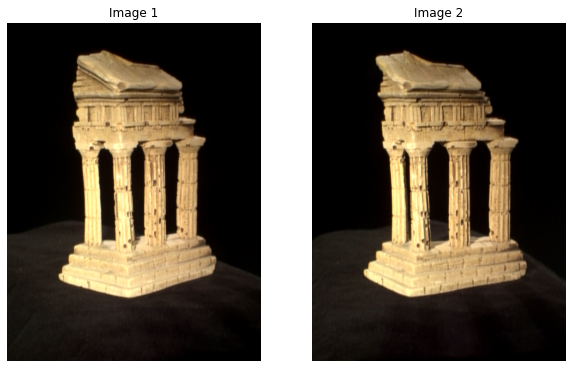

In [11]:
im1 = cv.imread('../data/im1.png')
im1 = cv.cvtColor(im1, cv.COLOR_BGR2RGB)

im2 = cv.imread('../data/im2.png')
im2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2 ,1)
ax.imshow(im1)
ax.set_title('Image 1')
ax.set_axis_off()

ax = fig.add_subplot(1, 2 ,2)
ax.imshow(im2)
ax.set_title('Image 2')
ax.set_axis_off()

plt.show()

point_corresp = np.load('../data/some_corresp.npz')
pts1 = point_corresp[point_corresp.files[0]]
pts2 = point_corresp[point_corresp.files[1]]

In [12]:
pmax = np.max(im1.shape)
F = eight_point(pts1, pts2, pmax)
print('F = ', F)

Optimization terminated successfully.
         Current function value: 0.000106
         Iterations: 55
         Function evaluations: 6068
F =  [[-1.59040577e-09  1.20994619e-07 -2.86914834e-06]
 [ 6.79859633e-08  4.68623480e-11 -1.13237810e-03]
 [-1.61329335e-05  1.08910347e-03  4.44256016e-03]]


In [13]:
# displayEpipolarF(im1, im2, F)

In [14]:
# epipolarMatchGUI(im1, im2, F)

In [15]:
Ks = np.load("../data/intrinsics.npz")
K1 = Ks[Ks.files[0]]
K2 = Ks[Ks.files[1]]
E = essential_matrix(F, K1, K2)
print('E = ', E)

E =  [[-3.67640768e-03  2.80704897e-01  4.03209801e-02]
 [ 1.57725964e-01  1.09112923e-04 -1.69651548e+00]
 [ 2.58391580e-04  1.71769668e+00  1.97646824e-03]]


In [16]:
def best_M2(M2s, M1, K2, pts1, pts2_est):
    num_of_points = []
    for i, M2ex in enumerate(M2s):
        M2 = K2@M2ex
        pts3D = triangulate(M1, pts1_temple, M2, pts2_temple)
        num_of_points.append(np.count_nonzero(pts3D[:, 2] > 0))

    chosen_i = np.argmax(num_of_points)
    chosen_M2 = M2s[chosen_i]
    return chosen_M2

In [17]:
R1 = np.eye(3)
t1 = np.zeros((3, 1))
M1ex = np.concatenate((R1, t1), axis=1)
M1 = K1 @ M1ex
M2s = camera2(E)

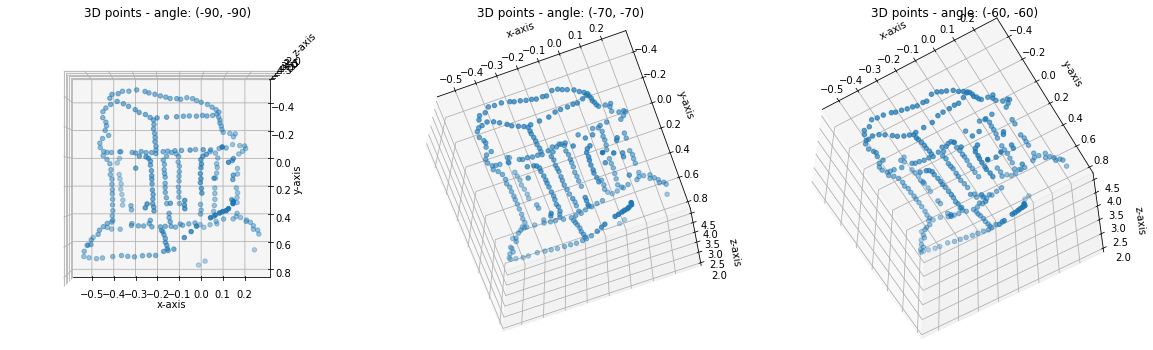

In [18]:
point_temple = np.load('../data/temple_coords.npz')
pts1_temple = point_temple[point_temple.files[0]]
pts2_temple = epipolar_correspondences(im1, im2, F, pts1_temple)

M2s = np.moveaxis(M2s, -1, 0)
M2ex = best_M2(M2s, M1, K2, pts1_temple, pts2_temple)

M2 = K2 @ M2ex
pts3D = triangulate(M1, pts1_temple, M2, pts2_temple)
angles = [(-90, -90), (-70, -70), (-60, -60)]

fig = plt.figure(figsize=(20,20))

for i, angle in enumerate(angles):
    ax = fig.add_subplot(len(angles), len(angles), i+1, projection='3d')
    xs = pts3D[:,0]
    ys = pts3D[:,1]
    zs = pts3D[:,2]
    ax.scatter(xs, ys, zs)
    ax.set_title(f'3D points - angle: {angle}')
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

plt.show()


In [19]:
print(f'R1 = {R1}\n')
print(f't1 = {t1}\n')

print(f'R2 = {M2ex[:, :3]}\n')
print(f't2 = {M2ex[:, 3].reshape(-1, 1)}')

R1 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t1 = [[0.]
 [0.]
 [0.]]

R2 = [[ 0.96747413 -0.02361054  0.25186575]
 [ 0.02318694  0.99972033  0.00465   ]
 [-0.2519051   0.00134124  0.96775101]]

t2 = [[-1.        ]
 [-0.02357655]
 [ 0.16342086]]


In [20]:
def calc_error(pts3D, M, pts):
    ones = np.ones((len(pts3D), 1))
    pts3D_4cor = np.array(np.concatenate((pts3D, ones), axis=1))

    pts1_est = (M @ pts3D_4cor.T).T
    pts1_est[:,:] = pts1_est[:,:]/pts1_est[:,2][:, np.newaxis]
    pts1_est = np.delete(pts1_est, 2, axis=1)
    pts1_est = pts1_est.astype(np.int)

    re_projection_error = np.mean(np.sqrt(np.sum((pts1_est-pts)**2, axis=1)))
    return re_projection_error

In [21]:
pts3D = triangulate(M1, pts1, M2, pts2)

pts1_error = calc_error(pts3D, M1, pts1)
print(f'pts1 re-projection Error: {np.round(pts1_error, 3)}')

pts2_error = calc_error(pts3D, M2, pts2)
print(f'pts2 re-projection Error: {np.round(pts2_error, 3)}')

pts1 re-projection Error: 1.79
pts2 re-projection Error: 2.445


* Example result:

<center> <img src = "assets/pointcloud_example.jpg" style="width:75%">
<center> Figure 4 - Sample Reconstructions.

### <img src="https://img.icons8.com/external-ddara-lineal-ddara/64/000000/external-yoga-pose-yoga-poses-ddara-lineal-ddara-36.png" style="height:50px;display:inline"> Part 2 - Pose Estimation - Bonus
---
In this section, you will implement what you have learned in class to estimate the intrinsic and extrinsic parameters of camera given 2D points $p$ on image and their corresponding 3D points $P$. In other words, given a set of matched points $\left\{P_i ,p_i\right\}$ and camera model (in homogeneous coordinates):

$$ p = M P$$

we want to find the estimate of the camera matrix $M\in \mathbb{R}^{3\times4}$, as well as intrinsic parameter
matrix $K\in \mathbb{R}^{3\times3}$, camera rotation $R\in \mathbb{R}^{3\times3}$ and camera translation $t\in \mathbb{R}^{3\times1}$, such that:
$$ M = K \left[R \lvert t\right] $$

#### 2.1 - Estimating $M$
---
* Write a function that estimates the camera matrix $M$ given 2D and 3D points $p,P$.

In [22]:
def estimate_pose(p, P):
    """
    Camera Matrix Estimation
    [I] p, 2D points (Nx2 matrix)
        P, 3D points (Nx3 matrix)
    [O] M, camera matrix (3x4 matrix)
    """
    # replace pass by your implementation
    pass

where `p` is $2\times N$ matrix denoting the $(x, y)$ coordinates of the $N$ points on the image plane and `P` is $3\times N$ matrix denoting the $(x,y,z)$ coordinates of the corresponding points in the 3D world. Recall that this camera matrix can be computed using the same strategy as homography estimation by Direct Linear Transform (DLT).

* Once you finish this function, you can run the following script to test your implementation:

In [23]:
# 1. Generate random camera matrix
K = np.array([[1,0,100], [0,1,100], [0,0,1]])
R, _,_ = la.svd(np.random.randn(3,3))
if la.det(R) < 0: R = -R
t = np.vstack((np.random.randn(2,1), 1))
M = K @ np.hstack((R, t))

# 2. Generate random 2D and 3D points
N = 100
P = np.random.randn(N,3)
p = M @ np.hstack((P, np.ones((N,1)))).T
p = p[:2,:].T / np.vstack((p[2,:], p[2,:])).T

# 3. Test pose estimation with clean points
Mc = estimate_pose(p, P)
pp = Mc @ np.hstack((P, np.ones((N,1)))).T
pp = pp[:2,:].T / np.vstack((pp[2,:], pp[2,:])).T

print('Reprojection Error with clean 2D points:', la.norm(p-pp))
print('Pose Error with clean 2D points:', la.norm((Mc/Mc[-1,-1])-(M/M[-1,-1])))

# 4. Test pose estimation with noisy points
p = p + np.random.rand(p.shape[0], p.shape[1])
Mn = estimate_pose(p, P)
pp = Mn @ np.hstack((P, np.ones((N,1)))).T
pp = pp[:2,:].T / np.vstack((pp[2,:], pp[2,:])).T

print('Reprojection Error with noisy 2D points:', la.norm(p-pp))
print('Pose Error with noisy 2D points:', la.norm((Mn/Mn[-1,-1])-(M/M[-1,-1])))

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

* **In your write-up**: Please include the output of this script in your PDF.

#### 2.2 - Intrinsic/Extrinsic Parameters
---
* Write a function that estimates both intrinsic and extrinsic parameters from a camera matrix:

In [ ]:
def estimate_params(M):
    """
    Camera Parameter Estimation
    [I] M, camera matrix (3x4 matrix)
    [O] K, camera intrinsics (3x3 matrix)
        R, camera extrinsics rotation (3x3 matrix)
        t, camera extrinsics translation (3x1 matrix)
    """
    # replace pass by your implementation
    pass

From what we learned on class, the `estimate_params` function should consecutively run the following steps:
* Compute the camera center $c$ by using SVD. Hint: $c$ is the eigenvector corresponding to the smallest eigenvalue.
* Compute the intrinsic $K$ and rotation $R$ by using QR decomposition. $K$ is a right upper triangle matrix while $R$ is an orthonormal matrix.
* Compute the translation by $t = -Rc$.

* Once you finish this function, you can run the following script to test your implementation:

In [ ]:
# 1. Generate random camera matrix
K = np.array([[1,0,100], [0,1,100], [0,0,1]])
R, _,_ = la.svd(np.random.randn(3,3))
if la.det(R) < 0: R = -R
t = np.vstack((np.random.randn(2,1), 1))
M = K @ np.hstack((R, t))

# 2. Generate random 2D and 3D points
N = 100
P = np.random.randn(N,3)
p = M @ np.hstack((P, np.ones((N,1)))).T
p = p[:2,:].T / np.vstack((p[2,:], p[2,:])).T

# 3. Test parameter estimation with clean points
Mc = estimate_pose(p, P)
Kc, Rc, tc = estimate_params(Mc)

print('Intrinsic Error with clean 2D points:', la.norm((Kc/Kc[-1,-1])-(K/K[-1,-1])))
print('Rotation Error with clean 2D points:', la.norm(R-Rc))
print('Translation Error with clean 2D points:', la.norm(t-tc))

# 4. Test parameter estimation with noisy points
p = p + np.random.rand(p.shape[0], p.shape[1])
Mn = estimate_pose(p, P)
Kn, Rn, tn = estimate_params(Mn)

print('Intrinsic Error with noisy 2D points:', la.norm((Kn/Kn[-1,-1])-(K/K[-1,-1])))
print('Rotation Error with noisy 2D points:', la.norm(R-Rn))
print('Translation Error with noisy 2D points:', la.norm(t-tn))

* **In your write-up**: Please include the output of this script in your PDF.

#### 2.3 - Projecting CAD Models to 2D
---
Now you will utilize what you have implemented to estimate the camera matrix from a real image, shown in Figure 5 (left), and project the 3D object (CAD model), shown in Figure 5 (right), back on to the image plane. 

<center> <img src = "assets/airplane_image_CAD.jpg" style="width:75%">
<center> Figure 5 - The provided image and 3D CAD model.

Write a script that does the following:
* Load an image `image`, a CAD model `cad`, 2D points `x` and 3D points `X` from the data file `data/pnp.npz`.
* Run `estimate_pose` and `estimate_params` to estimate camera matrix $M$, intrinsic matrix $K$, rotation matrix $R$, and translation $t$.
* Use your estimated camera matrix $M$ to project the given 3D points $P$ onto the image.
* Plot the given 2D points $p$ and the projected 3D points on screen. An example is shown in Figure 6 (left).
* Draw the CAD model rotated by your estimated rotation $R$ on screen. An example is shown in Figure 6 (middle).
* Project the CAD's all vertices onto the image and draw the projected CAD model overlapping with the 2D image. An example is shown in Figure 6 (right).
* **In your write-up**: Please include the three images similar to Figure 6 in your PDF. You must use different colors from Figure 6. For example, green circle for given 2D points, black points for projected 3D points, blue CAD model, and red projected CAD model overlapping on the image. You will get **NO credit** if you use the same color.

* Example result:

<center> <img src = "assets/airplane_projection.jpg" style="width:100%">
<center> Figure 6 - Project a CAD model back onto the image. Left: the image annotated with given 2D points (blue circle) and projected 3D points (red points); Middle: the CAD model rotated by estimated R; Right: the image overlapping with
projected CAD model.

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> References & Credits
* Carnegie Mellon University - CMU
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
